<a href="https://colab.research.google.com/github/pauloacs/Deep-Learning-for-solving-the-poisson-equation/blob/main/PINN_phi_script_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/all_data_vanKarman_reduced_complete.hdf5' all_data.hdf5

In [1]:
from numba import njit
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import numpy as np
import math

def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:117, 0:200:5, ...]
    y = hdf5_file["sim_data"][:117, 1:201:5, ...]
    hdf5_file.close()

    times = 49

    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.
  
    max_0 = np.max( x[...,0] )
    max_1 = np.max( x[...,1] )
    max_2 = np.max( x[...,2] )

    x_mod = x * (x!=-100)

    min_0 = np.min( x_mod[...,0] )
    min_1 = np.min( x_mod[...,1] )
    min_2 = np.min( x_mod[...,2] )

    max_min_list = [max_0, max_1, max_2 , min_0 , min_1 ,min_2]


    y = y[...,0:3]

    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))* min_0 )/(max_0 - min_0)
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))* min_1 )/(max_1 - min_1)
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))* min_2 )/(max_2 - min_2)

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))* min_0 )/(max_0 - min_0)
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))* min_1 )/(max_1 - min_1)
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))* min_2 )/(max_2 - min_2)


    t = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2] ,1))

    for i in range(x.shape[1]):
      t[:,i,:,:] = np.ones((x.shape[0],x.shape[2],1)) * (i - math.floor(i/(times+1))*(times+1) ) * 0.1

    x = np.concatenate((x,t), axis=3)



    total_sim = x.shape[0]

    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]



    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, max_min_list

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test, max_min_list = read_dataset(hdf5_path, split=0.9, print_shape=True)


assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))


path = '/content/obstacle.hdf5'
hdf5_file = h5py.File(path, "r")

coords = hdf5_file["obstacle"][...]

hdf5_file.close()


def denormalize_data(input):

  ux = input[...,0:1]
  uy = input[...,1:2]
  p = input[...,2:3]

  ux = (max_0 - min_0) * ux  + np.ones((ux .shape))*min_0
  uy = (max_1 - min_1) * uy + np.ones((uy.shape))*min_1
  p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

  x_new = np.concatenate([ux, uy, p], axis = -1)
  
  return x_new
  

max_0 = max_min_list[0]
max_1 = max_min_list[1]
max_2 = max_min_list[2]

min_0 = max_min_list[3]
min_1 = max_min_list[4]
min_2 = max_min_list[5]

@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

indice = index(np.array(x_test[0,0,:,0]) , -100.0 )[0]

coords_data = x_test[0:1,:,:indice,3:6]

N= indice
T = coords_data.shape[1]

x_cord = coords_data[...,0].flatten().reshape(1,N*T,1)
y_cord = coords_data[...,1].flatten().reshape(1,N*T,1)
t_cord = coords_data[...,2].flatten().reshape(1,N*T,1)

x_data = np.concatenate([x_cord,y_cord,t_cord], axis=-1).reshape(1, 1,N*T, 3)

#introduce the initial condition: - starting from 0

x_data_initial = x_test[0:1,0:1,:indice,3:6]
x_data_initial[0:1,0:1,:,2:3] = np.zeros(shape=(x_data_initial[...,2:3].shape))
x_data = np.concatenate([x_data_initial , x_data], axis=2)

data = tf.data.Dataset.from_tensor_slices(x_data)

 #----------------</ data with initial condition >-------------------

ux = y_test[0,:,:indice,0].flatten().reshape(1,N*T,1)
uy = y_test[0,:,:indice,1].flatten().reshape(1,N*T,1)
p  = y_test[0,:,:indice,2].flatten().reshape(1,N*T,1)

ux = (max_0 - min_0) *ux + np.ones((ux.shape))*min_0
uy = (max_1 - min_1) *uy + np.ones((uy.shape))*min_1
p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

y_data = np.concatenate([ux,uy,p], axis=-1).reshape(1,N*T, 3)

y_true_initial = x_test[0,0:1,:indice,0:3]

ux = y_true_initial[...,0:1]
uy = y_true_initial[...,1:2]
p = y_true_initial[...,2:3]

ux = (max_0 - min_0) * ux  + np.ones((ux .shape))*min_0
uy = (max_1 - min_1) * uy + np.ones((uy.shape))*min_1
p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

y_true_initial = np.concatenate([ux,uy,p], axis=-1)

y_data = np.concatenate([y_true_initial , y_data], axis=1)

print('x_data.shape'+ str(x_data.shape))
print('y_data.shape'+ str(y_data.shape))

import random

def separate_data(coords):
    x = x_data[0,0:1,indice:,...]

    indice_cords = index(coords[0,:,0] , -100.0 )[0]

    coords = coords[0:1,:indice_cords,:]

    mask_obstacle = np.zeros((x_data[0,0:1,:,1].shape), dtype = bool)

    for i in range(coords.shape[1]):
      mask_obstacle = mask_obstacle | ( np.isclose(x_data[0,:,:,0:2],  coords[:,i,:])[...,0] & np.isclose(x_data[0,:,:,0:2],  coords[:,i,:])[...,1])

    mask_obstacle = mask_obstacle[:,indice:]  #excluding the IC

    y_max = np.max(x[:,:,1])
    y_min = np.min(x[:,:,1])

    mask_wall = np.isclose(x[:,:,1],y_max) | np.isclose(x[:,:,1],y_min)
    n_wall = np.sum(mask_wall)
    
    x_max = np.max(x[:,:,0])
    x_min = np.min(x[:,:,0])

    mask_outlet = np.isclose(x[:,:,0],x_max)

    n_outlet = np.sum(mask_wall)

    mask_inlet = np.isclose(x[:,:,0],x_min)

    n_inlet = np.sum(mask_inlet)

    n_obstacle = np.sum(mask_obstacle)


    X_inlet = x_data[0,:,indice:,:][mask_inlet != 0]
    X_outlet = x_data[0,:,indice:,:][mask_outlet != 0]

    X_wall = x_data[0,:,indice:,:][mask_wall != 0]
    X_obstacle = x_data[0,:,indice:,:][mask_obstacle != 0]
    X_walls = np.concatenate((X_wall,X_obstacle), axis=0)

    X_IC = x_data[0,0,:indice,:]

    n_Samples = 100000
    idx_f_model = random.sample(range(0, x_data.shape[2]), n_Samples)

    X_in = np.take(x_data[0,0,...], idx_f_model ,axis=0)
    Y_in = np.take(y_data[0,...], idx_f_model ,axis=0)


    X_in = tf.cast(X_in, dtype='float32')
    X_inlet = tf.cast(X_inlet, dtype='float32')
    X_outlet = tf.cast(X_outlet, dtype='float32')
    X_walls = tf.cast(X_walls, dtype='float32')
    X_IC = tf.cast(X_IC, dtype='float32')

    return X_inlet, X_outlet, X_walls, X_IC, X_in


X_inlet, X_outlet, X_walls, X_IC, X_in = separate_data(coords)

lb = np.min(x_data[0,0:1,:,0:3], axis=1)
ub = np.max(x_data[0,0:1,:,0:3], axis=1)


def normalize_X(X):
  x_norm  = 2.0 *(X[...,0:1]-lb[0][0])/(ub[0][0]-lb[0][0])-1.0 
  y_norm  = 2.0 *(X[...,1:2]-lb[0][1])/(ub[0][1]-lb[0][1])-1.0 
  t_norm  = 2.0 *(X[...,2:3]-lb[0][2])/(ub[0][2]-lb[0][2])-1.0 
  X_normalized = tf.concat([x_norm, y_norm , t_norm], axis = -1)
  return X_normalized


def dense_model():
  input_layer = tf.keras.Input (shape=( 3))
  x = tf.keras.layers.Lambda(normalize_X)(input_layer)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  x = tf.keras.layers.Dense(50, activation='tanh')(x)
  output_layer = tf.keras.layers.Dense(2)(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

def net_uv(data):

    dtype = "float32"
    x = tf.convert_to_tensor(data[...,0:1], dtype=dtype)
    y = tf.convert_to_tensor(data[...,1:2], dtype=dtype)
    t = tf.convert_to_tensor(data[...,2:3], dtype=dtype)

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)
      tape.watch(y)

      psip = model_ref(tf.stack([x, y, t], axis=1))
      psi = psip[...,0:1]
      p = psip[...,1:2]
      ux = tape.gradient(psi, y)
      uy = - tape.gradient(psi, x)

    return ux, uy, p

def net_f(data):

    dtype = "float32"
    x = tf.convert_to_tensor(data[...,0:1], dtype=dtype)
    y = tf.convert_to_tensor(data[...,1:2], dtype=dtype)
    t = tf.convert_to_tensor(data[...,2:3], dtype=dtype)

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)
      tape.watch(y)
      tape.watch(t)

      psi_p_sigma = model_ref(tf.stack([x,y,t], axis=1))

      psi = psi_p_sigma[:,0:1]
      p = psi_p_sigma[:,1:2]

      u = tape.gradient(psi, y)
      v = tape.gradient(-psi, x)

      u_x = tape.gradient(u,x)
      u_y = tape.gradient(u,y)

      v_x = tape.gradient(v, x)
      v_y = tape.gradient(v,y)

    u_t = tape.gradient(u,t)
    v_t = tape.gradient(v,t)

    u_xx = tape.gradient(u_x,x)
    u_yy = tape.gradient(u_y,y)

    v_xx = tape.gradient(v_x,x)
    v_yy = tape.gradient(v_y,y)

    p_x = tape.gradient(p,x)
    p_y = tape.gradient(p,y)

    nu= 1.51e-4
    NSx_residual = tf.square(u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy))
    NSy_residual = tf.square(v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy))

    # cont_residual = tf.reduce_mean(tf.square(cont_residual))
    NSx_residual = tf.reduce_mean(tf.square(NSx_residual))
    NSy_residual = tf.reduce_mean(tf.square(NSy_residual))

    loss_equations = NSx_residual + NSy_residual

    return loss_equations

U_mean = 1
h = 0.5

u_inlet_true = 1.5 * U_mean * np.square( np.ones(X_inlet[:,1:2].shape) - abs(X_inlet[:,1:2])/h )

def eq_loss_NS_2():
  def equation_loss(X_inlet, X_outlet, X_IC, X_walls, X_in, u_inlet_true):

      loss_eq = net_f(X_in)
      u_inlet, v_inlet, _  =  net_uv(X_inlet)
      _ , _ , p_outlet =  net_uv(X_outlet)
      u_IC, v_IC, p_IC =  net_uv(X_IC)
      u_walls, v_walls, _ =  net_uv(X_walls)

      loss_wall = tf.reduce_mean(tf.square(u_walls)) + tf.reduce_mean(tf.square(v_walls))
      loss_inlet = tf.reduce_mean(tf.square(u_inlet - u_inlet_true)) + tf.reduce_mean(tf.square(v_inlet))
      loss_outlet = tf.reduce_mean(tf.square(p_outlet))
      loss_IC = tf.reduce_mean(tf.square(u_IC)) + tf.reduce_mean(tf.square(v_IC)) + tf.reduce_mean(tf.square(p_IC))

      return     loss_eq + 5 * loss_wall + 5 *loss_inlet + loss_outlet + loss_IC

  return equation_loss


loss_object1 = tf.keras.losses.MeanSquaredError()

def perform_validation():
  losses = []

  for step, (x_batch_test) in enumerate (data):

    x_batch_test = tf.cast(x_batch_test, dtype='float32')
    ux,uy,p  = net_uv(x_batch_test[0,...])
    val_logits = tf.concat([ux, uy, p] , axis=1)


    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object1(y_true= y_data[0:1,:,0:3] , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses

#coding the training
@tf.function
def apply_gradient(optimizer, model , x):
  with tf.GradientTape() as tape:
    #logits = model_ref(x)  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(X_inlet, X_outlet, X_IC, X_walls, X_in, u_inlet_true)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return loss_value # logits, loss_value 

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train) in enumerate (data):

    x_batch_train = tf.cast(x_batch_train, dtype='float32')
    
    loss_value = apply_gradient(optimizer , model_ref , x_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    #progbar.update(step+1)

  return losses

model_ref = dense_model()
loss_object = eq_loss_NS_2()
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)


#from tqdm import tqdm 
import math


epochs = 1000
epochs_val_losses, epochs_train_losses = [], []

train_len = 1

for epoch in range(epochs):
  
  #progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  #epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)
  #print('Epoch %s: loss: %.4f \n' % (epoch,float(losses_train_mean)), flush = True)
  print('Epoch %s: loss: %.4f real_loss: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean)), flush = True)
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()

import numpy
import tensorflow as tf
import tensorflow_probability as tfp


def function_factory(model, loss, x, y_true):#, y_prev):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(X_inlet, X_outlet, X_IC, X_walls, X_in, u_inlet_true)
        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        #grad_flat = []
        #for g in grads:
        #    grad_flat.append(tf.reshape(g, [-1]))
        #grad_flat = tf.concat(grad_flat, 0)

        ux,uy,p = net_uv(x[0,...])
        val_logits = tf.concat([ux, uy, p] , axis=1)

        val_loss = loss_object1(y_true= y_data[0,:,0:3] , y_pred = val_logits[:,:])

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value, "loss_val:", val_loss)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)


#model = load_model('my_model.h5')
# use float64 by default
#tf.keras.backend.set_floatx("float32")

for step, (x_batch_train) in enumerate (data):
  x = tf.cast(x_batch_train, dtype='float32')

loss = eq_loss_NS_2()
func = function_factory(model_ref, loss, x, y_data[0:1,:,0:3])#, y_prev)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, model_ref.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=5000, tolerance=1e-10)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
print(*func.history, sep='\n')



total_sim: 1
x_train.shape: (0, 40, 14000, 6)
y_train.shape: (0, 40, 14000, 3)
x_test.shape: (1, 40, 14000, 6)
y_test.shape: (1, 40, 14000, 3)

x_data.shape(1, 1, 529720, 3)
y_data.shape(1, 529720, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
__________________________________________________________

KeyboardInterrupt: ignored

test which code is the fastest

In [ ]:
import time

ux, uy, p = net_uv(x_data[0,...])

ux = ux[:,indice:,0]
uy = uy[:,indice:,0]
p =  p[:,indice:,0]


start_time = time.time()

for i in range(50):

  ux_inlet_BC = y_data[:,indice:,0][mask_inlet != 0]

  ux_inlet_pred = ux[mask_inlet != 0]
  uy_inlet_pred = uy[mask_inlet != 0]

  loss_u_inlet = tf.reduce_mean(tf.square(ux_inlet_BC - ux_inlet_pred)) + tf.reduce_mean(tf.square(uy_inlet_pred))


print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

for i in range(50):

  ux_inlet_BC = y_data[:,indice:,0]*mask_inlet

  ux_inlet_pred = ux*mask_inlet
  uy_inlet_pred = uy*mask_inlet

  loss_u_inlet = tf.reduce_sum(tf.square(ux_inlet_BC - ux_inlet_pred))/n_inlet + tf.reduce_sum(tf.square(uy_inlet_pred))/n_inlet


print("--- %s seconds ---" % (time.time() - start_time))

--- 0.21057748794555664 seconds ---
--- 0.1858210563659668 seconds ---


In [ ]:
print(mask_inlet.shape)
print(x_data.shape)
x_data[0,0:1,indice:,0][mask_inlet == 0]

(1, 258400)
(1, 1, 271320, 3)


array([0.0101389 , 0.0101389 , 0.0304167 , ..., 4.95015001, 4.97008991,
       4.99002981])

In [ ]:
model_ref.compile(optimizer,loss_object)
#loss_object = tf.keras.losses.MeanSquaredError()

# score = model_ref.evaluate(x_data[0,...],y_data, verbose=1)

# print('Average Mean Squared Error:', score)
model_ref.save('my_model_ref.h5')

In [ ]:
from google.colab import files
files.download('my_model_ref.h5') 

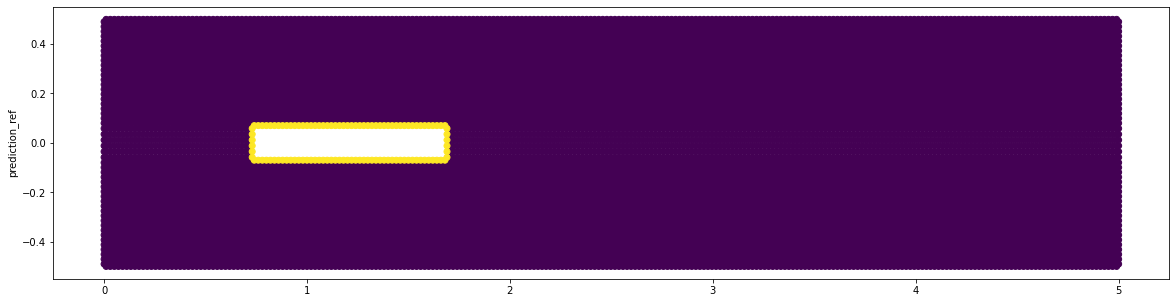

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

time = 0

fig = plt.figure(figsize= (20,5))
# plt.scatter(x = x_data[0,0,:indice,3], y = x_data[0,0,:indice,4], c = y_prev[0,(time)*indice:(time+1)*indice,0], cmap='jet', vmax=1.5 ,vmin=-1.0 )
# plt.colorbar()

plt.ylabel('prediction_ref')
plt.scatter(x = x_data[0,0,:indice,0], y = x_data[0,0,:indice,1], c = mask_obstacle[0,:indice] )




In [ ]:
pip install idaes-pse

In [ ]:
import numpy as np
import idaes.surrogate.pysmo.sampling as rbf
data = rbf.LatinHypercubeSampling(x_test[0,:,:indice,:], 1000, sampling_type="selection")
data = data.sample_points()

In [ ]:
import random 
idx_f_model = random.sample(range(0, indice) , 700 )#x_data.shape[2]), 10000)

x = np.take(x_data[0,0:1,:indice,0:1], idx_f_model, axis=1)
y = np.take(x_data[0,0:1,:indice,1:2], idx_f_model, axis=1)
t = np.take(x_data[0,0:1,:indice,2:3], idx_f_model, axis=1)

plt.scatter(x[0,:,0],y[0,:,0])


In [ ]:
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[...],y[...],t[...])

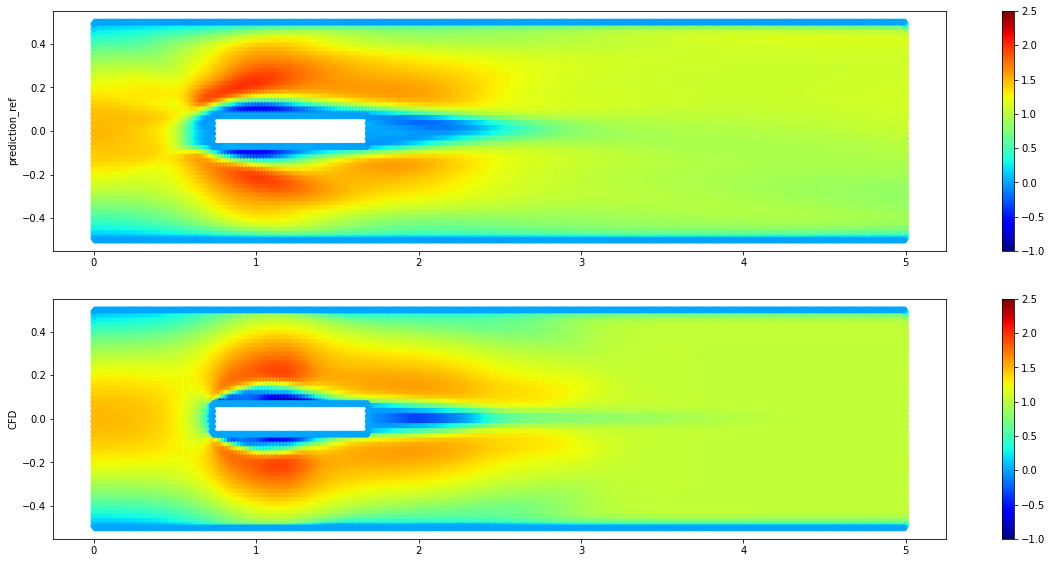

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

time = 1

fig = plt.figure(figsize= (20,15))
# plt.scatter(x = x_data[0,0,:indice,3], y = x_data[0,0,:indice,4], c = y_prev[0,(time)*indice:(time+1)*indice,0], cmap='jet', vmax=1.5 ,vmin=-1.0 )
# plt.colorbar()

ux, uy, uz = net_uv(x_data[0,...])

plt.subplot(311)
plt.ylabel('prediction_ref')
plt.scatter(x = x_data[0,0,:indice,0], y = x_data[0,0,:indice,1], c = ux[0,(time)*indice:(time+1)*indice,0], cmap='jet', vmax=2.5 ,vmin=-1 )
plt.colorbar()


plt.subplot(312)
plt.ylabel('CFD')
plt.scatter(x = x_data[0,0,:indice,0], y = x_data[0,0,:indice,1], c =  y_data[:,:,0:3][0,(time)*indice:(time+1)*indice,0], cmap='jet', vmax=2.5 ,vmin=-1.0 )
plt.colorbar()
